In [1]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
import random

from PIL import Image
from skimage.color import rgb2gray
import xml.etree.ElementTree as ET
from skimage import io, exposure, filters


import matplotlib.pyplot as plt

## 2) Used XML processing modules :

In [2]:
# Directory for images and annotations
image_dir = "./images"
annotation_dir = "./annotation"

In [3]:
#breeds of dogs assign to me
class_names = "Malamute,Kerry_blue_terrier,German_short-haired_pointer,Welsh_springer_spaniel".split(",")

In [4]:
#print the name of class
class_names

['Malamute',
 'Kerry_blue_terrier',
 'German_short-haired_pointer',
 'Welsh_springer_spaniel']

In [5]:
class_paths = os.listdir(image_dir)

In [6]:
class_paths

['n02110063-malamute',
 'n02093859-Kerry_blue_terrier',
 'n02100236-German_short-haired_pointer',
 'n02102177-Welsh_springer_spaniel']

## Cropping and Resize Images 

In [7]:
def resize_crop_image(image_path,image_filename,annotation_path,annotation_filename):
  bnd_box = []
  im = Image.open(os.path.join(image_path,image_filename))
  annotation = ET.parse(os.path.join(annotation_path,annotation_filename))
  annotation_root = annotation.getroot()
  for child in annotation_root.findall('object')[0].findall('bndbox')[0]:
    bnd_box.append(int(child.text))
  im = im.crop(bnd_box)
  im = im.resize((128,128))
  return im
new_dir = "./updated/"
if not os.path.exists(new_dir):
  os.mkdir(new_dir)
for class_ in class_paths:
  image_class_path = os.path.join(image_dir,class_)
  annotation_class_path = os.path.join(annotation_dir,class_)
  images = os.listdir(image_class_path)
  annotations = os.listdir(annotation_class_path)
  new_class_dir = os.path.join("./updated/",class_)
  images.sort()
  annotations.sort()
  if not os.path.exists(new_class_dir):
    os.mkdir(new_class_dir)
  for image_filename ,annotation_filename in zip(images,annotations):
    im = resize_crop_image(image_class_path,image_filename,annotation_class_path,annotation_filename)
    im.save(os.path.join(new_class_dir,image_filename))

## (b) Feature extraction 

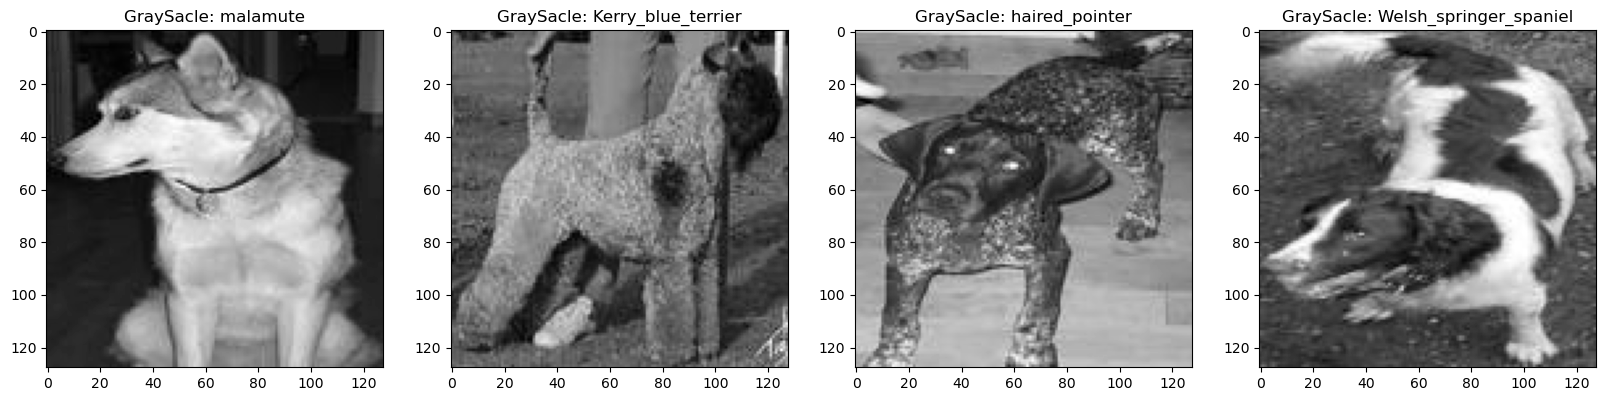

In [8]:
updated_class = os.listdir("./updated")
images_to_convert =[]
for class_ in updated_class:
  filenames =random.choices(os.listdir(os.path.join("./updated",class_)),k=1)
  for filename in filenames:
    images_to_convert.append(os.path.join(class_,filename))
fig, axes = plt.subplots(1,4, figsize=(20,10))
for ax,filename in zip(axes.flat,images_to_convert):
  img = cv.imread(os.path.join("./updated",filename))
  gray_sacle = rgb2gray(img)
  ax.imshow(gray_sacle, cmap=plt.cm.gray)
  ax.set_title("GraySacle: " + filename.split("/")[0].split("-")[-1])
plt.show()

## Part (3),(4) and (5)

In [9]:
def angle(dx, dy):
    #Calculate the angles between horizontal and vertical operators.
    return np.mod(np.arctan2(dy, dx), np.pi)

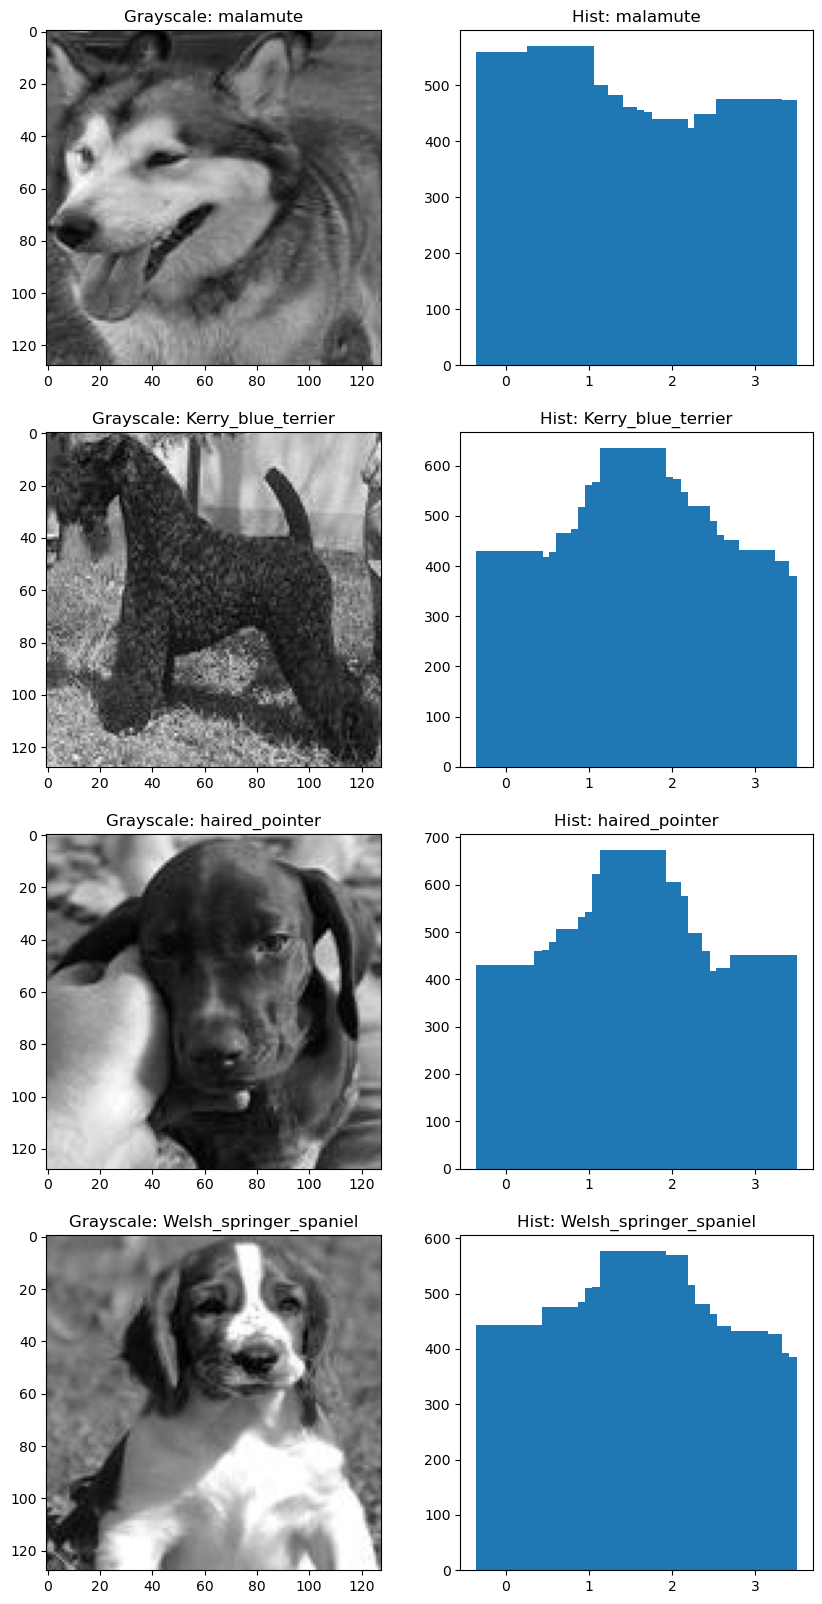

In [10]:
updated_class = os.listdir("./updated")
images_to_angle =[]
for class_ in updated_class:
  filenames =random.choices(os.listdir(os.path.join("./updated",class_)),k=1)
  for filename in filenames:
    images_to_angle.append(os.path.join(class_,filename))

fig, axes = plt.subplots(4,2, figsize=(10,20))
ax=axes.flat
c =0
for i in range(len(images_to_angle)):
  img = cv.imread(os.path.join("./updated",images_to_angle[i]))
  gray_sacle = rgb2gray(img)
  angle_sobel = angle(filters.sobel_h(gray_sacle),
  filters.sobel_v(gray_sacle))
  hist,bins = exposure.histogram(angle_sobel,nbins=36)
  ax[c].imshow(gray_sacle, cmap=plt.cm.gray)
  ax[c+1].bar(bins,hist)
  ax[c].set_title("Grayscale: "+images_to_angle[i].split("/")
  [0].split("-")[-1])
  ax[c+1].set_title("Hist: "+images_to_angle[i].split("/")
  [0].split("-")[-1])
  c+=2
plt.show()

## Part (6 )

In [11]:
updated_class = os.listdir("./updated")
class_one_images = 'n02110063-malamute/n02110063_15416.jpg'
class_two_images = 'n02102177-Welsh_springer_spaniel/n02102177_2532.jpg'

img = cv.imread(os.path.join("./updated",class_one_images))
gray_sacle = rgb2gray(img)
angle_sobel = angle(filters.sobel_h(gray_sacle),
filters.sobel_v(gray_sacle))
hist,bins = exposure.histogram(angle_sobel,nbins=36)
class_one_hist = hist

img = cv.imread(os.path.join("./updated",class_two_images))
gray_sacle = rgb2gray(img)
angle_sobel = angle(filters.sobel_h(gray_sacle),
filters.sobel_v(gray_sacle))
hist,bins = exposure.histogram(angle_sobel,nbins=36)
class_two_hist = hist

def euclidean_distance(x,y):
  return np.sqrt(np.sum((x-y)**2))
    
def manhattan_distance(x,y):
  return np.sum(abs(x-y))
    
def cosine_distance(x,y):
  return np.sum(x+y)/(np.sqrt(np.sum(x**2))*np.sqrt(np.sum(y**2)))

print("Euclidean Distannce :",euclidean_distance(class_one_hist,class_two_hist))

print("Manhattan distance :",manhattan_distance(class_one_hist,class_two_hist))

print("Cosine distance :",cosine_distance(class_one_hist,class_two_hist))




Euclidean Distannce : 521.1736754672093
Manhattan distance : 2586
Cosine distance : 0.0042408797600181555


## Part (c)

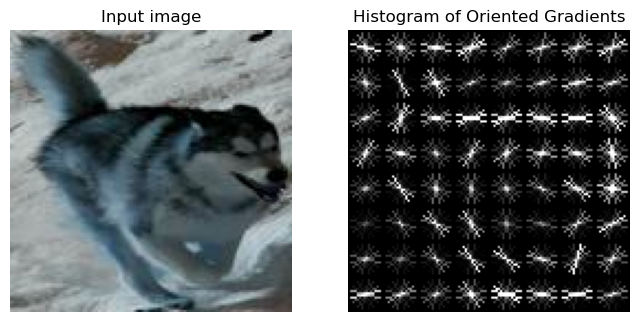

In [12]:
from skimage.feature import hog
image = cv.imread("./updated/n02110063-malamute/n02110063_15416.jpg")
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True,channel_axis=-1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True,sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image,in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)

ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## Part (d)

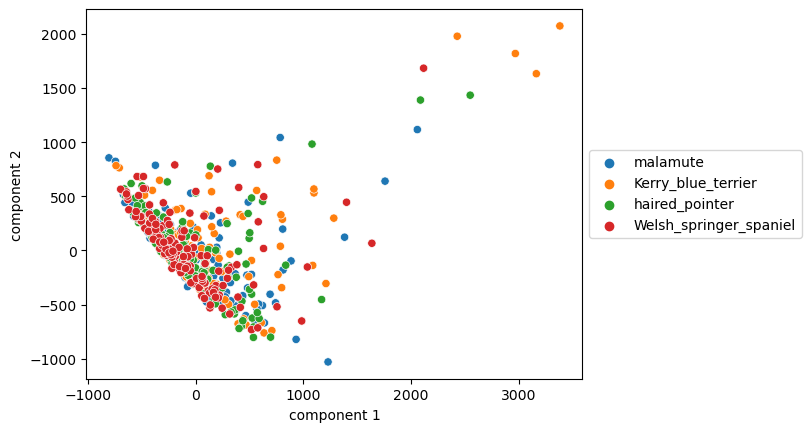

In [13]:
updated_class = os.listdir("./updated")
import pandas as pd
columns=[i for i in range(36)] + ["label"]
df = pd.DataFrame(columns=columns)
for class_ in updated_class:
  class_path = os.path.join("./updated",class_)
  for filename in os.listdir(class_path):
    img = cv.imread(os.path.join(class_path,filename))
    gray_sacle = rgb2gray(img)
    angle_sobel = angle(filters.sobel_h(gray_sacle),
    filters.sobel_v(gray_sacle))
    hist,bins = exposure.histogram(angle_sobel,nbins=36)
    df.loc[len(df)] = list(hist)+[class_.split("-")[-1]]

X_train = np.array(df[df.columns[:-1]])
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(X_train)
df_pca = pd.DataFrame(data_pca)
df_pca['label'] = df['label']
import seaborn as sns
sns.scatterplot(x=df_pca[0],y=df_pca[1],hue=df_pca['label'])
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### There is no classes are visually separable for this data.

## Part (3) 

In [14]:
import json


data = []
with open('./student_23/train.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

# Convert the list of JSON objects to a DataFrame
df = pd.DataFrame(data)

# Display the first few rows
df.head()


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-11049,"— Self-hatred gives rise to fury, fury to the ...",True,False,True,False,False,False,True,False,True,False,False
1,2017-En-21451,#Question of the #day: what are some of your #...,False,False,False,True,False,False,False,False,False,False,False
2,2017-En-40232,What a sad day...1st day of Fall...I don't dis...,False,False,False,False,False,False,False,True,True,False,False
3,2017-En-21892,Michael Carrick should start every game for Un...,False,True,False,False,False,False,True,False,False,False,True
4,2017-En-30496,@smoothkobra after such a heavy 2 days this ha...,False,False,False,False,True,True,False,False,False,False,False


In [15]:
emotion_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
df['label'] = df[emotion_columns].idxmax(axis=1)
df[['Tweet', 'label']].head()


,Tweet,label
0,"— Self-hatred gives rise to fury, fury to the ...",anger
1,#Question of the #day: what are some of your #...,fear
2,What a sad day...1st day of Fall...I don't dis...,pessimism
3,Michael Carrick should start every game for Un...,anticipation
4,@smoothkobra after such a heavy 2 days this ha...,joy


## Part(4) - countvectorizer and tfidvector

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Initialize vectorizers
count_vect = CountVectorizer()
tfidf_vect = TfidfVectorizer()

# Fit and transform the 'Tweet' column
X_counts = count_vect.fit_transform(df['Tweet'])
X_tfidf = tfidf_vect.fit_transform(df['Tweet'])

# Check the dimensionality
print("CountVectorizer shape:", X_counts.shape)
print("TfidfVectorizer shape:", X_tfidf.shape)


CountVectorizer shape: (3000, 9484)
TfidfVectorizer shape: (3000, 9484)


## Part (5) 

In [17]:
selected_classes = ['anger', 'anticipation', 'disgust', 'fear']
filtered_df = df[df['label'].isin(selected_classes)]

X_counts_filtered = X_counts[filtered_df.index]
X_tfidf_filtered = X_tfidf[filtered_df.index]

filtered_df = filtered_df.reindex(range(0,len(filtered_df)))


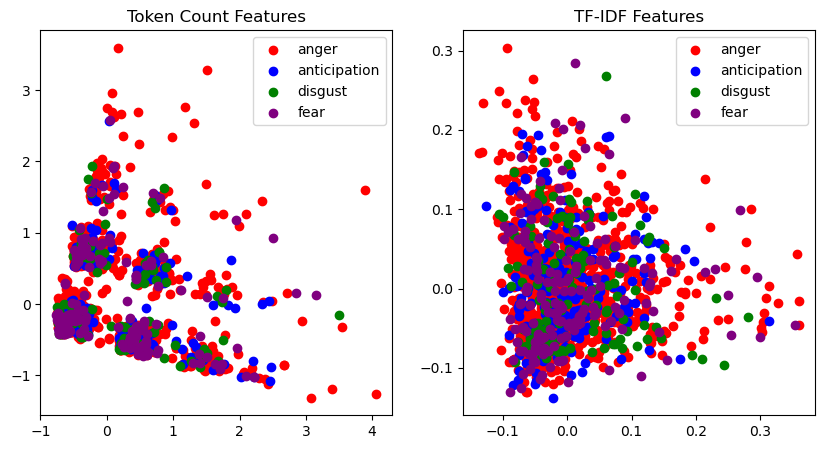

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)


X_counts_reduced = pca.fit_transform(X_counts_filtered.toarray())
X_tfidf_reduced = pca.fit_transform(X_tfidf_filtered.toarray())


colors = ['red', 'blue', 'green', 'purple']


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
for i,label in enumerate(selected_classes):
    indices = filtered_df[filtered_df['label'] == label].index
    plt.scatter(X_counts_reduced[indices, 0], X_counts_reduced[indices, 1], c=colors[i], label=label)
plt.title('Token Count Features')
plt.legend()


plt.subplot(1, 2, 2)
for i,label in enumerate(selected_classes):
    indices = filtered_df[filtered_df['label'] == label].index
    plt.scatter(X_tfidf_reduced[indices, 0], X_tfidf_reduced[indices, 1], c=colors[i], label=label)
plt.title('TF-IDF Features')
plt.legend()

plt.show()


## There is no classes are visually separable 